# Heavy Traffic Indicators on I-94

## Purpose

This is an exploratory data analysis of a dataset about the westbound traffic on the I-94 interstate highway that connects the Great Lakes and the northern Great Plains regions of the United States. The goal of the analysis is to identify indicators of heavy traffic on I-94. 

A parallel goal of this analysis is to demonstrate the effective use of the pyplot module of the matplotlib library in python. 

## Data

The data was collected and made available by John Hogue, and can be downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume). The data reflects the period between 2012-2018 and the original dataset contains 48204 instances of 9 attributes. 

### Loading and inspecting the data

In [1]:
import pandas as pd
traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
print(traffic.head(5))
print(traffic.tail(5))
print(traffic.info())

  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918  
      holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0   

### Visualizing `traffic_volume` data to identify useful trends

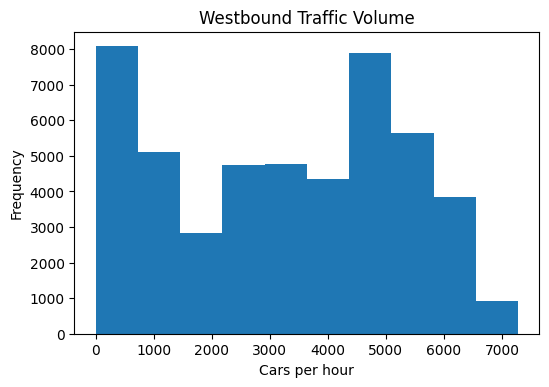

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

#plotting a histogram of the traffic volume data
plt.hist(traffic['traffic_volume'])
plt.xlabel('Cars per hour')
plt.ylabel('Frequency')
plt.title('Westbound Traffic Volume')
plt.show()

In [3]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

The histogram allows us to see that the number of westbound cars on I-94 passing station 301 varies between 0 and 7280 in an hour. The data is not normally distributed, and seems to have two distinct peaks - one around 0 (no traffic at all) and again around 5000 cars per hour. Undoubtedly other attributes in the dataset can help explain this variance in the distribution. 

#### Separation of Day and Night data

One factor influencing traffic volume is likely time of day. Presumably more motorists are on the road in the day time than in the night time. To explore this we can segregate our data into Day (7:00 - 19:00) and Night (19:00 - 7:00).

In [4]:
#start by converting the date_time column to datetime
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

day = traffic.copy()[(traffic['date_time'].dt.hour >=7) & (traffic['date_time'].dt.hour < 19)]
print(day.shape)

night = traffic.copy()[(traffic['date_time'].dt.hour >= 19) | (traffic['date_time'].dt.hour < 7)]
print(night.shape)

(23877, 9)
(24327, 9)


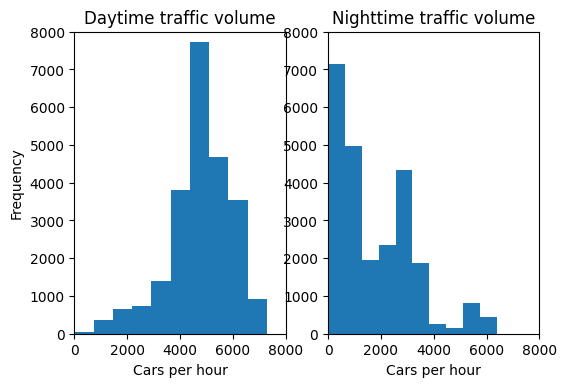

In [5]:
plt.figure()
plt.subplot(1,2,1)
plt.hist(day['traffic_volume'])
plt.xlabel('Cars per hour')
plt.ylabel('Frequency')
plt.title('Daytime traffic volume')
plt.ylim(0, 8000)
plt.xlim(0, 8000)

plt.subplot(1,2,2)
plt.hist(night['traffic_volume'])
plt.xlabel('Cars per hour')
plt.title('Nighttime traffic volume')
plt.ylim(0, 8000)
plt.xlim(0, 8000)
plt.show()

In [6]:
day['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [7]:
night['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

Segregation of the Day and Night data reveals that the seeming bimodality of the whole dataset `traffic_volume` was likely due to overlapping distributions for Day and Night data. The Night data is a right-skewed distribution with a mean of 1,785 cars per hour while the Day data is a left skewed distribution with a mean of 4,762 cars per hour. 

As the goal of our analysis is a better understanding of the factor contributing to heavy traffic, it would be best to continue the analysis focusing on the Day data, as that is when the heavy traffic is occurring. 

## Analysis

### Daytime traffic patterns as a function of time

#### Analysis of traffic by month

To investigate if there are any interesting monthly traffic patterns, group the daytime data isolated above by month of the year.

In [8]:
day['month'] = day['date_time'].dt.month
by_month = day.groupby('month').mean()

Plot a line graph of the data to visualize any interesting trends

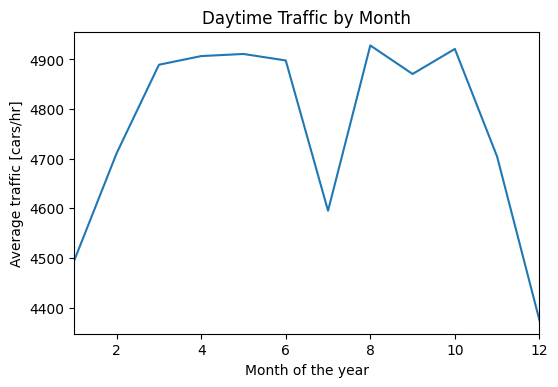

In [9]:
by_month['traffic_volume'].plot.line()
plt.xlabel('Month of the year')
plt.ylabel('Average traffic [cars/hr]')
plt.xlim(1, 12)
plt.title('Daytime Traffic by Month')
plt.show()

As one might expect for the midwest, where winters are especially cold and snowy, traffic is less dense during the winter months (November-February) and more bustling in the Spring, Summer, and early Fall. 

The exception to the above trend seems to be July - in the aggregate data there is a large dip in July traffic. One possibility is that July is a slow month for travel in this corridor. Another alternative possibility is that one particular event or year is driving this dip. To investigate further, I will plot the July data for each year to see if there are any outliers. 

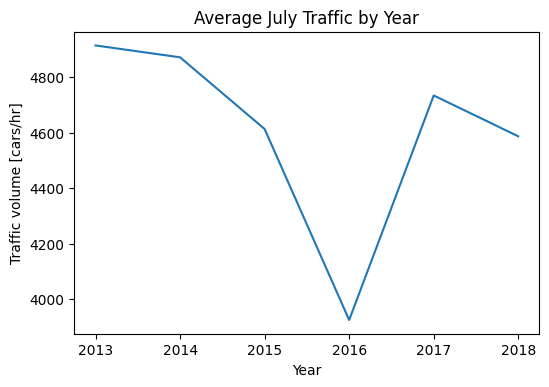

In [10]:
day['year'] = day['date_time'].dt.year
only_july = day[day['month'] == 7]
only_july.groupby('year').mean()['traffic_volume'].plot.line()
plt.xlabel('Year')
plt.ylabel('Traffic volume [cars/hr]')
plt.title('Average July Traffic by Year')
plt.show()

The above plot reveals that while most years July traffic was similar to that of other Summer months, in 2016 the traffic dropped precipitously only to rebound to normal levels the following year. This supports the idea that an event, such as road construction drove the low July average over the aggregated data set. 

#### Analysis of traffic by day of the week

If the particular stretch of I-95 is used for business more than leisure travel, we might expect to find that a greater volume of cars use the passage during weekdays than weekends. To expore this, the data can be segregated and analyzed by the day of the week

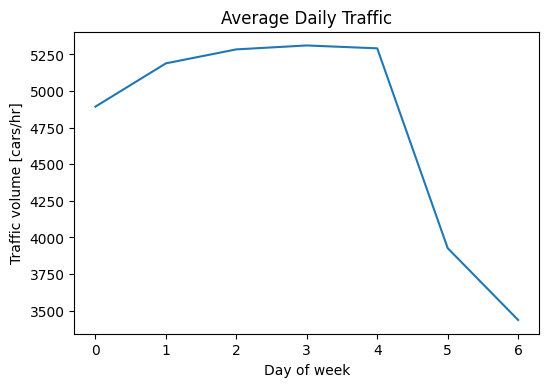

In [11]:
day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean() #in this system, Monday = 0, Sunday = 6
by_dayofweek['traffic_volume'].plot.line()
plt.xlabel('Day of week')
plt.ylabel('Traffic volume [cars/hr]')
plt.title('Average Daily Traffic')
plt.show()

In keeping with the possibility that the I-95 corridor is used heavily for business travel, there is a high volume of traffic during week days (about 4900-5300 cars per day), and a steep drop in traffic on the weekends (< 4000 cars per day). 

A further level of information we can glean from the day of the week information is time of day - how does traffic volume vary with the time of day for particular days of the week? To visualize this, the data can be broken into two groups - workday and weekend so that the trends from the clearly different groups can be viewed clearly. 

In [12]:
day['hour'] = day['date_time'].dt.hour
workday = day.copy()[day['dayofweek'] <=4] #Monday-Friday
weekend = day.copy()[day['dayofweek'] >=5] #Saturday-Sunday
by_hour_workday = workday.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

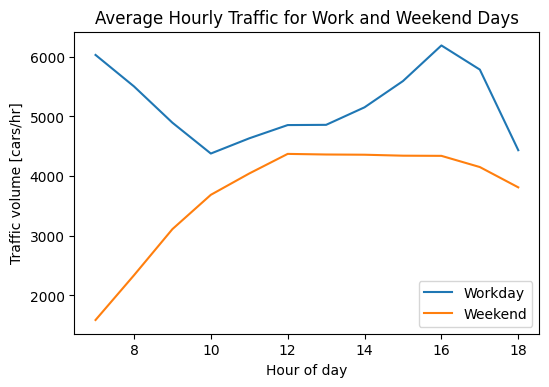

In [13]:
plt.plot(by_hour_workday['traffic_volume'], label = 'Workday')
plt.plot(by_hour_weekend['traffic_volume'], label = 'Weekend')
plt.legend()
plt.xlabel('Hour of day')
plt.ylabel('Traffic volume [cars/hr]')
plt.title('Average Hourly Traffic for Work and Weekend Days')
plt.show()

Unsurprisingly, on work or business days the traffic patterns show two peaks at what could be considered "rush hour" times: 7-8 am and 4-5 pm with lulls in between. On weekends, however, the traffic starts slow and gradually ramps to a peak around noon. On weekends, although traffic volume mounts, it doesn't ever reach workday levels. 

### Daytime traffic patterns as a function of weather

As hinted at above in the analysis of traffic volume by month, seasonal changes can affect traffic. On a more granular level, weather on a day-by-day or hour-by-hour basis can also affect traffic. To explore the effects of weather on traffic, I will start by querying the correlations between traffic volume and weather events categorized in the dataframe. 

The dataframe method of correlation calculation works for all numerical variables - of relevance to this analysis are `temp`, `rain_1h`, `snow_1h`, and `clouds_all`. 

In [14]:
day.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
year             -0.003557
dayofweek        -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

Of the weather-related variables above, the strongest correlation with `traffic_volume` is `temp`. Below is a scatterplot between these two variables.

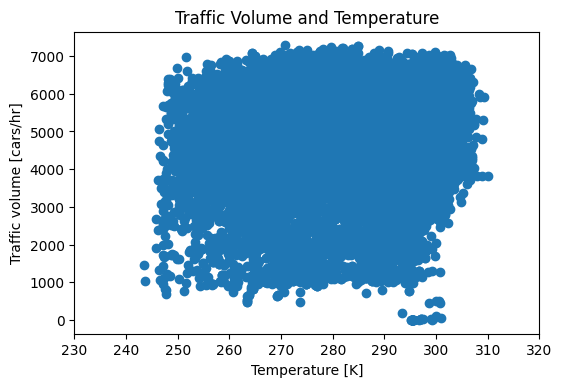

In [15]:
plt.scatter(day['temp'], day['traffic_volume'])
plt.xlabel('Temperature [K]')
plt.ylabel('Traffic volume [cars/hr]')
plt.title('Traffic Volume and Temperature')
plt.xlim(230, 320)
plt.show()

The scatter plot above demonstrates that even for the variable with the largest correlation with traffic volume, the data does not suppor the idea that weather events such as ralling/rising temperatures, rain, or snow have any relationship with traffic on I-95. 

In addition to the numerically categorized weather data in the dataset, there is categorical data listed under the columns `weather_main` and `weather_description`. To visualize their relationship with traffic volume we can use the mean to aggregate the data. 

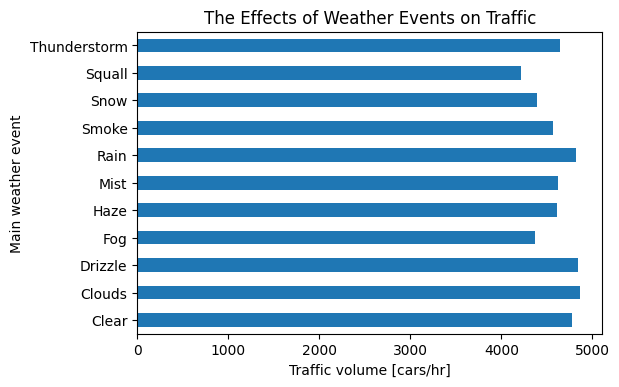

In [16]:
by_weather_main = day.groupby('weather_main').mean()
by_weather_desc = day.groupby('weather_description').mean()
# generate a bar plot for traffic volume by weather_main
by_weather_main['traffic_volume'].plot.barh()
plt.xlabel('Traffic volume [cars/hr]')
plt.ylabel('Main weather event')
plt.title('The Effects of Weather Events on Traffic')
plt.show()

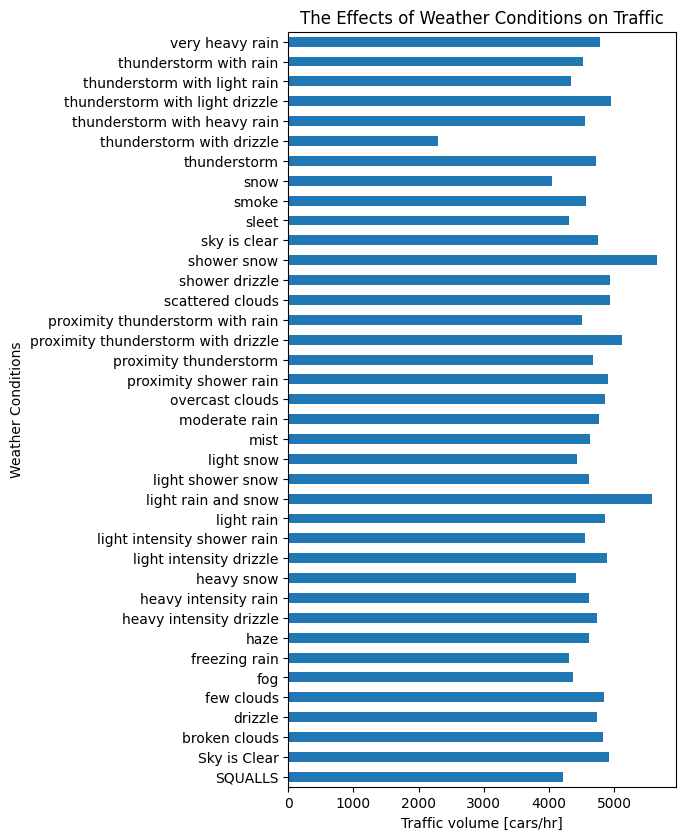

In [17]:
# generate a bar plot for traffic volume by weather_description
by_weather_desc['traffic_volume'].plot.barh(figsize=(5,10))
plt.xlabel('Traffic volume [cars/hr]')
plt.ylabel('Weather Conditions')
plt.title('The Effects of Weather Conditions on Traffic')
plt.show()

The data on weather events didn't reveal any that particularly affected traffic volume on I-94. Even the more granular investigation of descriptive weather events gave us only three that had an average of more than 5000 cars per hour: snow showers, local thunderstorms with drizzle, and light rain and snow. None of these conditions are especially bad weather, but perhaps they were just enough to convince people to drive somewhere rather than walk or bike. 

The assessment of the weather data leaves us with little to suggest that proximal weather conditions have much influence on heavy traffic. The more distal effects of seasonal weather are evident in traffic conditions, but there could be many contributing factors to those trends beyond weather. 

## Conclusions and Recommendations

The purpose of this analysis was to use graphical representations to identify key indicators of heavy traffic on Westbound I-94. The data suggest that several factors influnce the density of traffic on this roadway - in this analysis we have identified months of the year, days of the week, hours of the day, and middling bad weather as correlated with heavier traffic.
- Months of the year: Traffic on this monitored stretch of highway is heavier in the Spring, Summer, and early Fall, and falls off to lower levels on average in November-February. The exception to this was July of 2016, when a likely construction event disrupted the typical flow of traffic. 
- Days of the week: Traffic on I-94 is heavier on business days than on weekends, suggesting that this is an important route for commuters as well as commercial driving. 
- Hours of the day: Traffic on this highway is heavier during the day than during the night, particularly during the times that could be considered "rush-hours" (i.e., weekdays from 7-9 am and 4-6 pm). During the daytime hours of business days, traffic peaks twice, as mentioned above, and lulls in the between hours. No weekday lull dips quite as low, however, as weekend traffic, which builds steadily to asymptote around noon and drop slowly in the evening. 
- Unpleasant weather: While truly bad weather might be enough to keep cars off of the road completely, and very nice weather might inspire commuters to day-trippers to bike or walk, somewhat unpleasant weather might drive people out in cars. No weather events stood out as particularly influential in driving up traffic, and those coinciding with the highest average traffic volume were snow showers, thunderstorms with drizzle, and light rain and snow. 

In sum, if one wants to avoid heavy traffic on I-94, one should drive in Winter, on a weekend, at night. Alternatively, if you'd like to encounter as many other cars as possible, drive in a light August thunderstorm around 5 o'clock on a Friday. 